# III užduotis (Vaizdų klasifikavimas naudojant konvoliucinius neuroninius tinklus) database_data = 0.5

In [51]:
# Duomenų įkėlimas ir 80/10/10 padalinimas
from google.colab import drive
drive.mount('/content/drive')

import random
from pathlib import Path
from collections import Counter
DATASET = Path("/content/drive/MyDrive/Dataset")

classes = ['chihuahua', 'muffin']
train, val, test = [], [], []
database_data = 0.5

for i, c in enumerate(classes):
    files = list((DATASET / c).glob("*.jpg"))
    random.shuffle(files)
    n = len(files)
    n_train = int(n * 0.8 * database_data)
    n_val   = int(n * 0.1 * database_data)
    n_test  = int(n * 0.1 * database_data)

    train += [(str(f), i) for f in files[:n_train]]
    val   += [(str(f), i) for f in files[n_train:n_train+n_val]]
    test  += [(str(f), i) for f in files[n_train+n_val:n_train+n_val+n_test]]

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train: 2366, Val: 294, Test: 294


In [52]:
# subalansuojam kiekvieną aibę atskirai
def balance_pairs(pairs, seed=42):
    rng = random.Random(seed)
    by_lbl = {0: [], 1: []}
    for path, lbl in pairs:
        by_lbl[int(lbl)].append((path, int(lbl)))

    # Jei kuri nors klasė tuščia, grąžinam kaip yra (kad nesulūžtų)
    if min(len(by_lbl[0]), len(by_lbl[1])) == 0:
        return pairs

    # Sulyginam iki mažesnės klasės dydžio
    n = min(len(by_lbl[0]), len(by_lbl[1]))
    rng.shuffle(by_lbl[0]); rng.shuffle(by_lbl[1])
    balanced = by_lbl[0][:n] + by_lbl[1][:n]
    rng.shuffle(balanced)
    return balanced

train = balance_pairs(train)
val   = balance_pairs(val)
test  = balance_pairs(test)

def counts(pairs): return Counter(lbl for _, lbl in pairs)
print("Po balansavimo: ")
print("  train balance:", counts(train))
print("  val balance:  ", counts(val))
print("  test balance: ", counts(test))
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Po balansavimo: 
  train balance: Counter({0: 1087, 1: 1087})
  val balance:   Counter({1: 135, 0: 135})
  test balance:  Counter({1: 135, 0: 135})
Train: 2174, Val: 270, Test: 270


In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Pagrindiniai hiperparametrai
IMG_SIZE   = (128, 128)
BATCH_SIZE = 32
EPOCHS     = 10
LR         = 0.001
ACT        = "relu"              # Aktyvacijos funkcija: 'relu', 'tanh' 'sigmoid', 'softmax'
FILTERS    = (32, 64)            # Konvoliucinių sluoksnių filtrų skaičius
KERNEL     = 3                   # Branduolio (kernel) dydis konvoliucijose
POOL       = 2                   # Sujungimo (pooling) lango dydis
USE_BN     = True                # Ar naudoti Batch Normalization sluoksnius
DROPOUT    = 0.2                 # Dropout tikimybė
OPTIMIZER  = "adam"              # Optimizatorius ('adam' arba 'sgd')
LOSS       = "binary_crossentropy"  # Nuostolių funkcija dvejetainiam klasifikavimui (klases ir prognozes pasiskirstymo atsumas)

def _load_jpg(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3) # Dekoduojamas JPEG formato vaizdas į TensorFlow matricą (aukštis × plotis × 3 kanalai)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    img = tf.cast(img, tf.float32) / 255.0 # Pikseliu reikšmės paverčiamos į [0-1]
    return img, tf.cast(label, tf.float32) # Grąžinama apdorota nuotrauka ir jo 'klasė'

def make_ds(pairs, batch_size, training=False):
    paths, labels = zip(*pairs) # Path'us ir klases atskiriame į 2 sąrašus
    ds = tf.data.Dataset.from_tensor_slices((list(paths), list(labels))) # Sukuriame datasetą
    ds = ds.map(_load_jpg, num_parallel_calls=tf.data.AUTOTUNE) # nuskaitymas + resize + normalizacija

    if training:
        aug = keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.05),
        ])
        # Pritaikome apsukimą, pasvirimą ir sumaišymą
        ds = ds.shuffle(len(paths))
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.cache()  # kešuok po augmentacijos, kad per epochas neperkrautų
    else:
        ds = ds.cache()  # val/test – kešuojam po dekodavimo
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE) # Pagal sistemą pareinka kiek batch'ų pre-loadinti

# Paruošiame datasetus
train_ds = make_ds(train, BATCH_SIZE, training=True)
val_ds   = make_ds(val,   BATCH_SIZE, training=False)
test_ds  = make_ds(test,  BATCH_SIZE, training=False)

In [54]:
# Konvoliucinis blokas: Conv2D → (BatchNorm) → Aktivacija → MaxPool → (Dropout)
def conv_block(x, filters, kernel_size, pool_size, activation, use_bn, dropout): # Apdoroja vaizdą išgaudamas svarbiausius požymius
    x = layers.Conv2D(filters, kernel_size, padding="same", use_bias=not use_bn)(x) # išgauna vaizdo bruožus (pvz., kraštus, formas)
    if use_bn:
        x = layers.BatchNormalization()(x) # Normalizuoja reikšmes tarp sluoksnių (padeda stabilizuoti mokymą)
    x = layers.Activation(activation)(x) # Aktyvacijos funkcija (pvz., ReLU arba tanh)
    x = layers.MaxPooling2D(pool_size=pool_size)(x) # Sumažina vaizdo matmenis (pvz., 128x128 → 64x64), paliekant svarbiausią informaciją
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x) # Atsitiktinai išjungia dalį neuronų – sumažina permokymo (overfitting) riziką
    return x

# CNN konstruktorius: kelios konvoliucinės pakopos + sujungimo sluoksniai
def build_cnn(img_size, filters, activation, use_bn, dropout, kernel_size, pool_size):
    inp = layers.Input(shape=img_size + (3,)) # priima paveikslėlius nurodyto dydžio (aukštis, plotis, 3 spalvų kanalai)
    x = inp
    for f in filters:
        x = conv_block(x, f, kernel_size, pool_size, activation, use_bn, dropout) # kiekvienam filtrui kviečia konvoliucinį bloką (neuronai sluoksnyje)
    x = layers.Flatten()(x) # vaizdo duomenis ištiesinami į vieną ilgą vektorių
    x = layers.Dense(128, activation=activation)(x) # sujungiami visi neuronų bruožai į vieną sluoksnį
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid")(x) # Klasei isgauti naudojame 'sigmoid' aktyvacijos funkciją
    return keras.Model(inp, out) # Grąžinamas sukurtas modelis

# Kompiliavimas, kuriame apjungiamas: optimizatorius, nuostolių funkcija ir metrikos
def compile_model(model, lr=1e-3, optimizer="adam", loss="binary_crossentropy"):
    # Adam – adaptacinis metodas, automatiškai reguliuoja mokymosi greitį (dažniausiai geriausias pasirinkimas)
    # SGD – klasikinis „gradientinio nusileidimo“ metodas su momentum (pagreičiu)
    if optimizer == "adam":
        opt = keras.optimizers.Adam(learning_rate=lr)
    else:
        # W := W - η∇E + αΔW, čia α – momentum (čia 0.9) – įtraukiamas ankstesnių iteracijų „pagreitis“
        opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

# MOKYMAS
def train_once(cfg, train_ds, val_ds=None, epochs=10, verbose=0):
    model = build_cnn(IMG_SIZE, filters=cfg["filters"], activation=cfg["act"], use_bn=cfg["use_bn"], dropout=cfg["dropout"], kernel_size=cfg["k"], pool_size=cfg["p"]) # Sukuriamas modelis
    compile_model(model, lr=cfg["lr"], optimizer=cfg["optimizer"], loss=cfg.get("loss", "binary_crossentropy")) # Modelis kompiliuojamas (parenkamas optimizatorius, learning rate ir loss)

    # Apmoko modelį naudojant mokymo duomenis train_ds ir tikrina tikslumą su val_ds kiekvienoje epochoje
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose)

    # Randame, kuri epocha davė mažiausią klaidą (loss)
    if "val_loss" in history.history:
        best_idx = int(np.argmin(history.history["val_loss"]))
        val_acc  = float(history.history["val_accuracy"][best_idx])
        val_loss = float(history.history["val_loss"][best_idx])
    else:
        best_idx = int(np.argmin(history.history["loss"]))
        val_acc, val_loss = float("nan"), float("nan")

    # Grąžinami rezultatai (statistika ir pats modelis)
    return {
        "cfg": cfg,                                        # naudota konfigūracija
        "model": model,                                    # išmokytas modelis
        "hist": history.history,                           # visų epochų metrikos
        "best_ep": best_idx + 1,                           # geriausia epocha
        "tr_acc": float(history.history["accuracy"][best_idx]),
        "tr_loss": float(history.history["loss"][best_idx]),
        "va_acc": val_acc,
        "va_loss": val_loss
    }

In [55]:
# Lentelių braižymas
def plot_curves(history, title=""):
    plt.figure()
    plt.plot(history["accuracy"], label="train acc")
    if "val_accuracy" in history: plt.plot(history["val_accuracy"], label="val acc")
    plt.xlabel("Epocha"); plt.ylabel("Tikslumas"); plt.title(f"Accuracy {title}")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(history["loss"], label="train loss")
    if "val_loss" in history: plt.plot(history["val_loss"], label="val loss")
    plt.xlabel("Epocha"); plt.ylabel("Paklaida"); plt.title(f"Loss {title}")
    plt.legend(); plt.show()

def bar2(x_labels, y_train, y_val, title, x_label):
    idx = np.arange(len(x_labels)); w = 0.38
    plt.figure()
    plt.bar(idx - w/2, y_train, width=w, label="train")
    plt.bar(idx + w/2, y_val,   width=w, label="val")
    plt.xticks(idx, x_labels, rotation=15)
    plt.xlabel(x_label); plt.ylabel("Vertė"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 62s 136ms/step - accuracy: 0.5999 - loss: 14.2827 - val_accuracy: 0.5000 - val_loss: 0.7848
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7556 - loss: 0.5160 - val_accuracy: 0.5000 - val_loss: 0.9379
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7953 - loss: 0.4626 - val_accuracy: 0.5000 - val_loss: 1.3502
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8213 - loss: 0.4213 - val_accuracy: 0.5000 - val_loss: 1.8767
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8338 - loss: 0.3853 - val_accuracy: 0.5000 - val_loss: 1.8659
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8399 - loss: 0.3559 - val_accuracy: 0.5074 - val_loss: 1.4061
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8585 - loss: 0.3420 - val_accuracy: 0.5370 - val_loss: 1.4310
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8513 - loss: 0.3220 - val_accuracy: 0.6296 - val_l

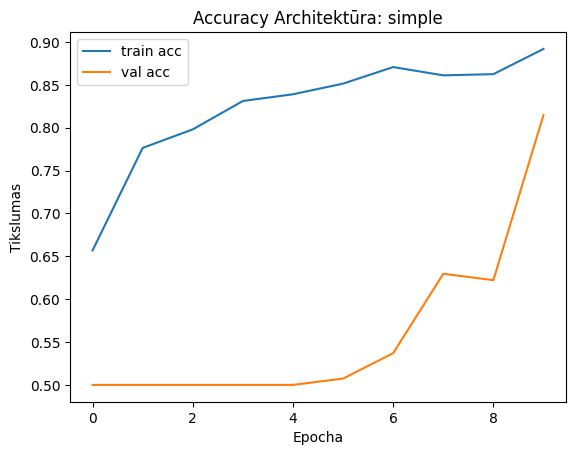

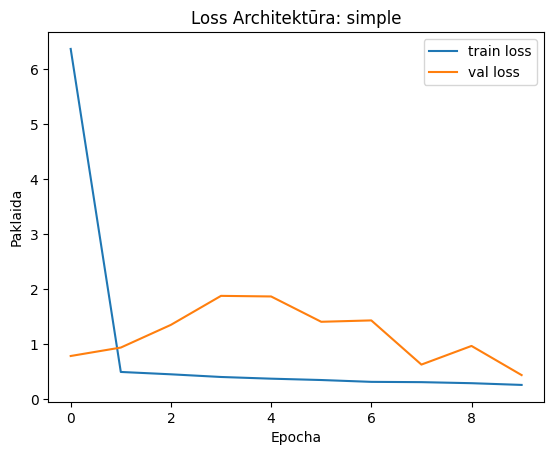

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.6147 - loss: 8.1878 - val_accuracy: 0.5000 - val_loss: 0.7563
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7672 - loss: 0.5023 - val_accuracy: 0.5000 - val_loss: 0.9697
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7893 - loss: 0.4304 - val_accuracy: 0.5000 - val_loss: 1.6201
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8287 - loss: 0.3883 - val_accuracy: 0.5000 - val_loss: 1.9196
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8430 - loss: 0.3504 - val_accuracy: 0.5000 - val_loss: 2.1186
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8598 - loss: 0.3120 - val_accuracy: 0.5074 - val_loss: 1.5846
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8636 - loss: 0.3198 - val_accuracy: 0.5037 - val_loss: 1.5877
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8621 - loss: 0.2917 - val_accuracy: 0.5333 - val_los

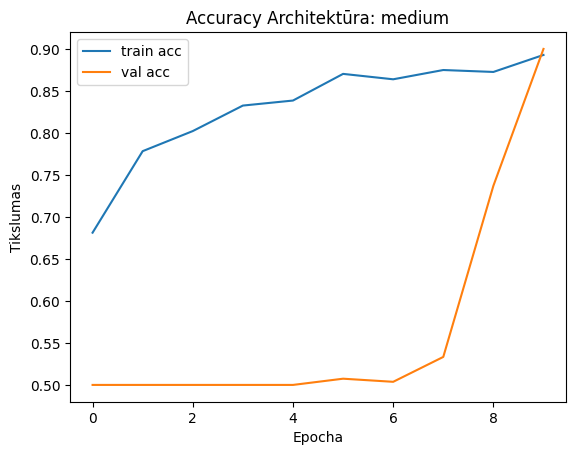

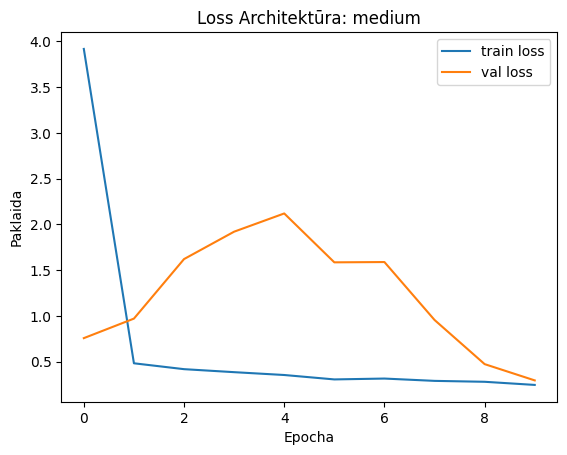

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.5804 - loss: 6.8495 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7602 - loss: 0.5134 - val_accuracy: 0.5000 - val_loss: 1.0022
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8063 - loss: 0.4377 - val_accuracy: 0.5000 - val_loss: 1.7536
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8304 - loss: 0.3804 - val_accuracy: 0.5000 - val_loss: 2.1672
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8403 - loss: 0.3636 - val_accuracy: 0.5000 - val_loss: 1.2676
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8502 - loss: 0.3376 - val_accuracy: 0.5481 - val_loss: 1.0254
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8595 - loss: 0.3023 - val_accuracy: 0.5037 - val_loss: 2.1990
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8758 - loss: 0.2768 - val_accuracy: 0.8481 - 

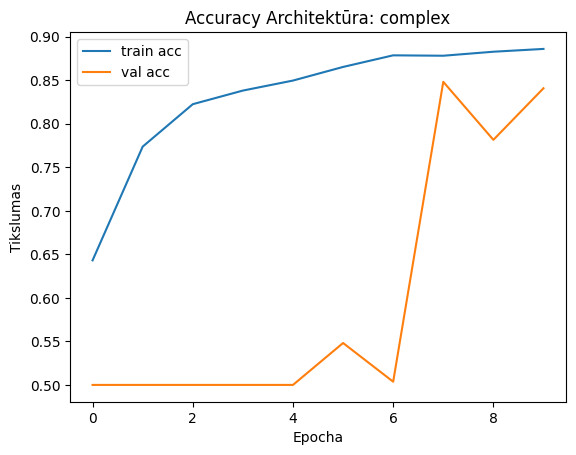

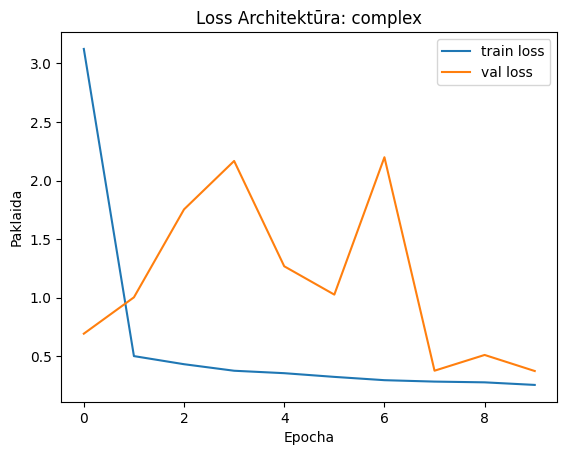

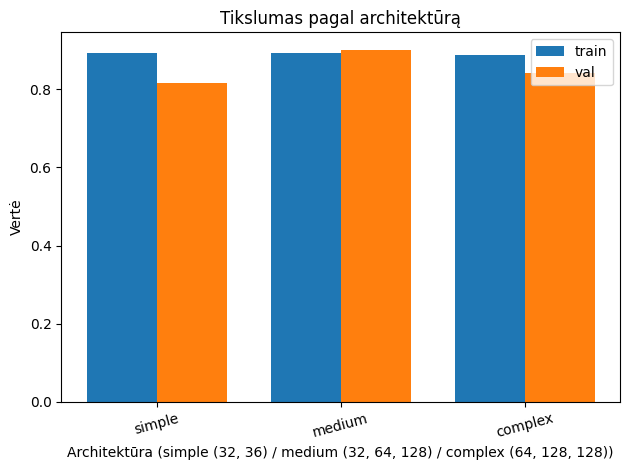

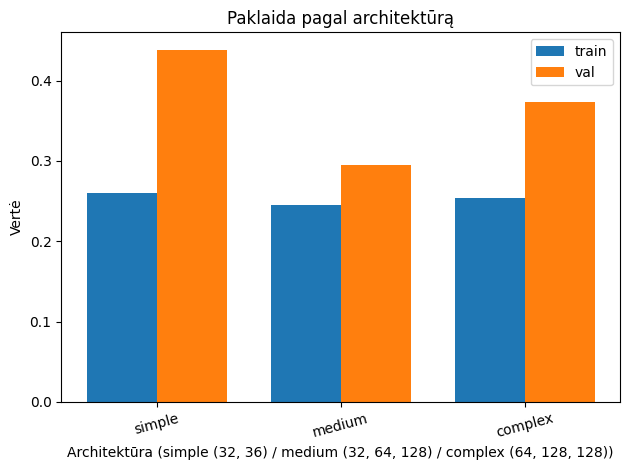

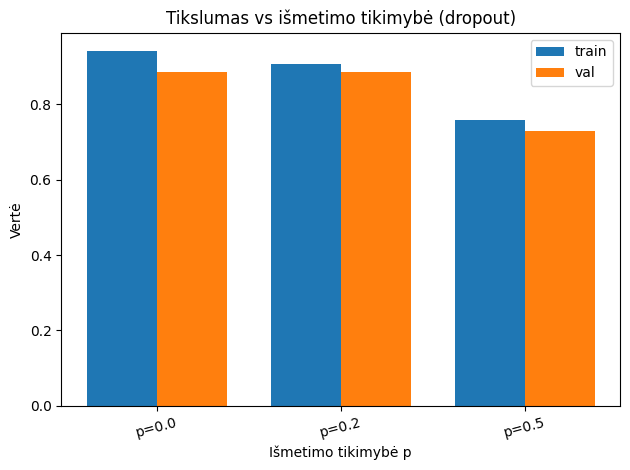

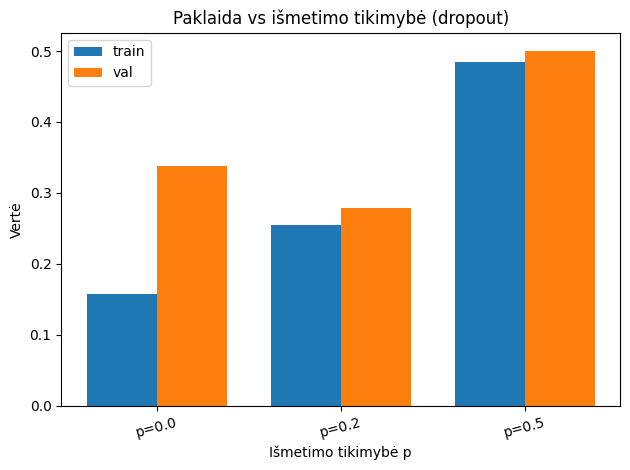

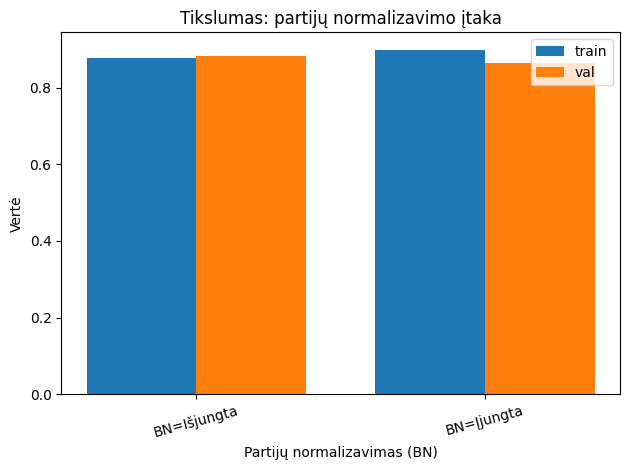

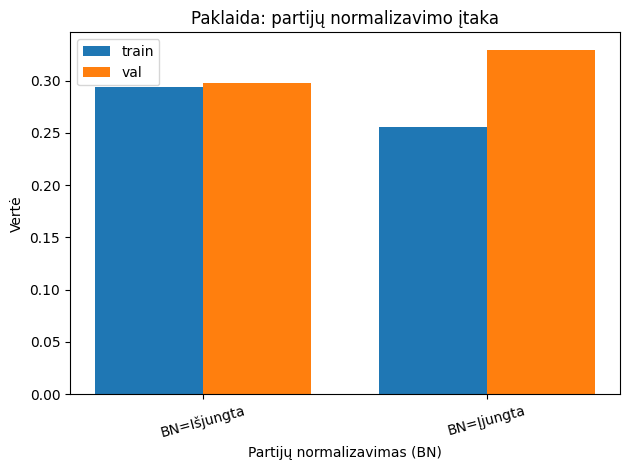

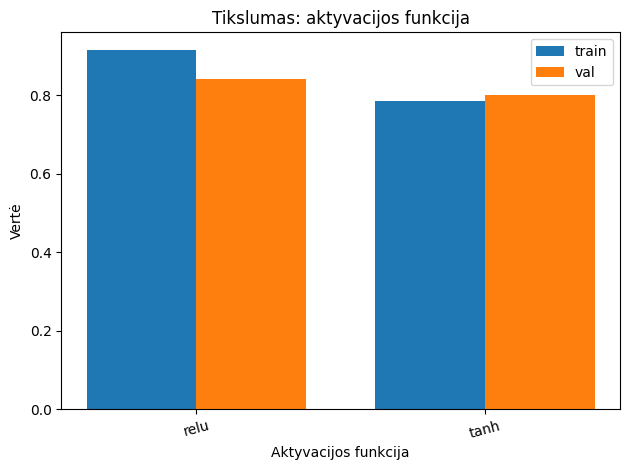

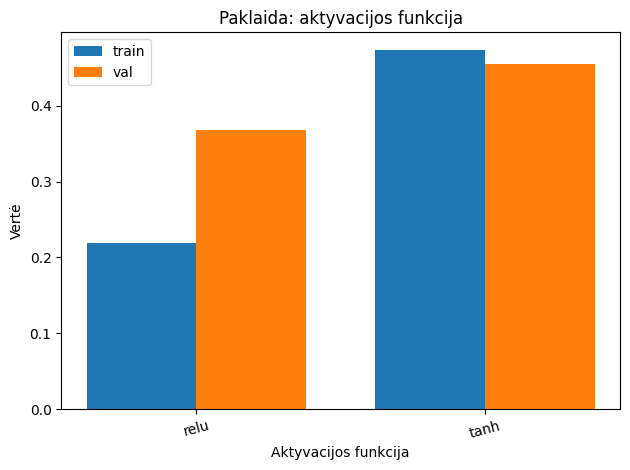

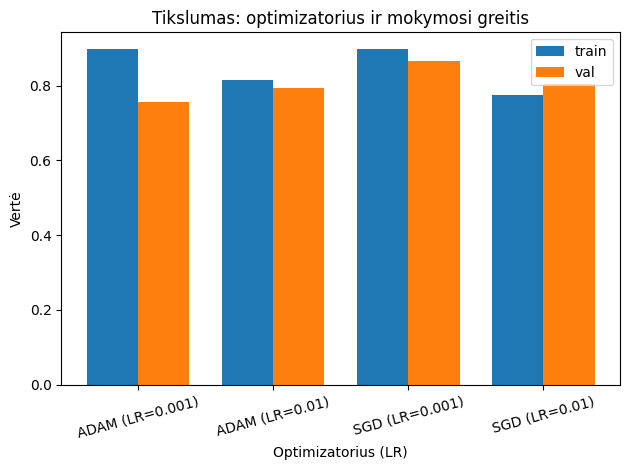

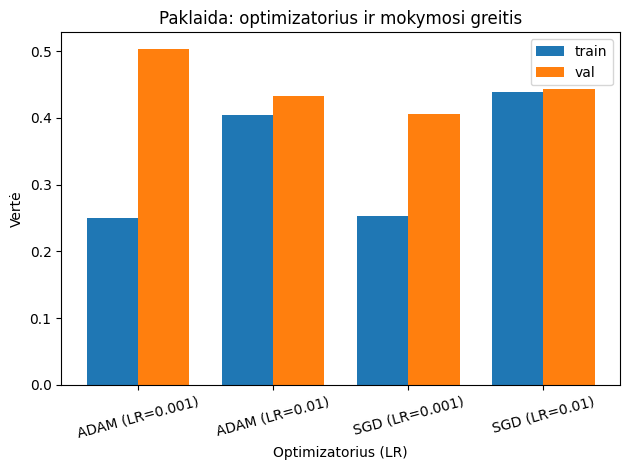

In [56]:
# TYRIMAS:
# Apibrėžiame tris CNN architektūras
ARCHS = [
    {"name": "simple",   "filters": (32, 64),       "k": 3, "p": 2},
    {"name": "medium",   "filters": (32, 64, 128),  "k": 3, "p": 2},
    {"name": "complex",  "filters": (64, 128, 128), "k": 3, "p": 2},
]
# Bendri parametrai
common = {"act": ACT, "use_bn": USE_BN, "dropout": DROPOUT, "lr": LR, "optimizer": OPTIMIZER, "k": KERNEL, "p": POOL}

# Architektūrų palyginimas
arch_runs = []
for A in ARCHS:
    cfg = {**common, **A}
    r = train_once(cfg, train_ds, val_ds, epochs=EPOCHS, verbose=1)
    arch_runs.append(r)
    plot_curves(r["hist"], title=f"Architektūra: {A['name']}")

x_arch = [r["cfg"]["name"] for r in arch_runs]
bar2(x_arch, [r["tr_acc"] for r in arch_runs], [r["va_acc"] for r in arch_runs], "Tikslumas pagal architektūrą", "Architektūra (simple (32, 36) / medium (32, 64, 128) / complex (64, 128, 128))")
bar2(x_arch, [r["tr_loss"] for r in arch_runs], [r["va_loss"] for r in arch_runs], "Paklaida pagal architektūrą", "Architektūra (simple (32, 36) / medium (32, 64, 128) / complex (64, 128, 128))")

# Pasirenkame geriausią architektūrą pagal validavimo rezultatus
base = max(arch_runs, key=lambda r: (r["va_acc"], -r["va_loss"]))["cfg"]

# Dropout (išmetimo tikimybė)
DROPS = [0.0, 0.2, 0.5]
drop_runs = []
for d in DROPS:
    cfg = {**base, "dropout": d}
    drop_runs.append(train_once(cfg, train_ds, val_ds))

drop_labels = [f"p={d}" for d in DROPS]
bar2(drop_labels, [r["tr_acc"] for r in drop_runs], [r["va_acc"] for r in drop_runs], "Tikslumas vs išmetimo tikimybė (dropout)", "Išmetimo tikimybė p")
bar2(drop_labels, [r["tr_loss"] for r in drop_runs], [r["va_loss"] for r in drop_runs], "Paklaida vs išmetimo tikimybė (dropout)", "Išmetimo tikimybė p")

# Partijų normalizavimas (BatchNorm)
BNs = [False, True]
bn_runs = []
for bn in BNs:
    cfg = {**base, "use_bn": bn}
    bn_runs.append(train_once(cfg, train_ds, val_ds))

bn_labels = ["BN=Išjungta", "BN=Įjungta"]
bar2(bn_labels, [r["tr_acc"] for r in bn_runs], [r["va_acc"] for r in bn_runs], "Tikslumas: partijų normalizavimo įtaka", "Partijų normalizavimas (BN)")
bar2(bn_labels, [r["tr_loss"] for r in bn_runs], [r["va_loss"] for r in bn_runs],"Paklaida: partijų normalizavimo įtaka", "Partijų normalizavimas (BN)")

# Aktyvacijos funkcija
ACTS = ["relu", "tanh"]
act_runs = []
for act in ACTS:
    cfg = {**base, "act": act}
    act_runs.append(train_once(cfg, train_ds, val_ds))

act_labels = ["relu", "tanh"]
bar2(act_labels, [r["tr_acc"] for r in act_runs], [r["va_acc"] for r in act_runs], "Tikslumas: aktyvacijos funkcija", "Aktyvacijos funkcija")
bar2(act_labels, [r["tr_loss"] for r in act_runs], [r["va_loss"] for r in act_runs], "Paklaida: aktyvacijos funkcija", "Aktyvacijos funkcija")

# Optimizatorius ir mokymosi greitis
OPTS = [("adam", 0.001), ("adam", 0.01), ("sgd", 0.001), ("sgd", 0.01)]
opt_runs = []
for opt, lr in OPTS:
    cfg = {**base, "optimizer": opt, "lr": lr}
    opt_runs.append(train_once(cfg, train_ds, val_ds))

opt_labels = [f"{o.upper()} (LR={lr:g})" for o, lr in OPTS]
bar2(opt_labels, [r["tr_acc"] for r in opt_runs], [r["va_acc"] for r in opt_runs], "Tikslumas: optimizatorius ir mokymosi greitis", "Optimizatorius (LR)")
bar2(opt_labels, [r["tr_loss"] for r in opt_runs], [r["va_loss"] for r in opt_runs], "Paklaida: optimizatorius ir mokymosi greitis", "Optimizatorius (LR)")

Geriausias modelis: {'act': 'relu', 'use_bn': True, 'dropout': 0.2, 'lr': 0.001, 'optimizer': 'adam', 'k': 3, 'p': 2, 'name': 'medium', 'filters': (32, 64, 128)} | val_acc: 0.9
Test accuracy: 0.8926 | Test loss: 0.2929


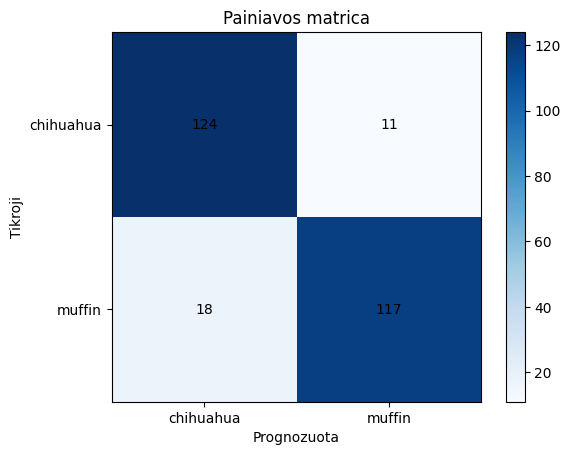

      Tikroji Prognozuota  Tikimybė (chihuahua=0 muffin=1)
0   chihuahua   chihuahua                            0.064
1      muffin      muffin                            0.975
2      muffin      muffin                            0.959
3      muffin      muffin                            1.000
4   chihuahua   chihuahua                            0.009
5   chihuahua   chihuahua                            0.013
6   chihuahua   chihuahua                            0.028
7   chihuahua   chihuahua                            0.057
8   chihuahua   chihuahua                            0.206
9   chihuahua      muffin                            0.971
10  chihuahua   chihuahua                            0.028
11  chihuahua   chihuahua                            0.074
12  chihuahua   chihuahua                            0.023
13  chihuahua   chihuahua                            0.186
14     muffin   chihuahua                            0.339
15  chihuahua   chihuahua                            0.0

In [57]:
# GERIAUSIO MODELIO TESTAS + KONFUZIJOS MATRICA + 30 PAVYZDŽIŲ
SELECT_BY = "val"
score = lambda r: (r["va_acc"], -r["va_loss"]) if SELECT_BY == "val" else (r["tr_acc"], -r["tr_loss"])
best_run = max(arch_runs + drop_runs + bn_runs + act_runs + opt_runs, key=score)
model = best_run["model"]
print("Geriausias modelis:", best_run["cfg"], "| val_acc:", round(best_run["va_acc"], 4))

#Testo metrikos
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Painiavos matrica
y_true, y_pred = [], []
for x, y in test_ds:
    probs = model.predict(x, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    y_pred += preds.tolist()
    y_true += y.numpy().astype(int).tolist()

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=2).numpy()
plt.imshow(cm, cmap="Blues"); plt.title("Painiavos matrica")
plt.xticks([0,1], classes); plt.yticks([0,1], classes)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Prognozuota"); plt.ylabel("Tikroji"); plt.colorbar(); plt.show()

# 30 testinių pavyzdžių (atsitiktinai išmaišome prieš .take)
rows = []
for img, true_lab in test_ds.unbatch().shuffle(1000, seed=7).take(30):
    p = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    pred_lab = int(p >= 0.5)
    true_idx = int(tf.cast(true_lab, tf.int32).numpy())
    rows.append({
        "Tikroji": classes[true_idx],
        "Prognozuota": classes[pred_lab],
        "Tikimybė (chihuahua=0 muffin=1)": round(float(p), 3)
    })

df_preds = pd.DataFrame(rows)
print(df_preds)